# 1. Blocker Fraud Company
 <font size="2"> Dados e problema negócio hipotéticos</font>
 
A Blocker Fraud Company é uma empresa especializada na detecção de fraudes em transações financeiras feitas atravś de dispositivos móveis.

O modelo de negócio da empresa é do tipo Serviço com a monetização feita por performance do serviço prestado, ou seja, o usuário paga uma taxa fixa sobre o sucesso da detecção de fraude das transações.

## 1.1. Estratégia de expansão

A Blocker Fraud Company está em fase de expansão no Brasil e para adquirir clientes mais rapidamente, ela adotou uma estratégia muito agressiva. A estratégia funciona da seguinte forma:

1. A empresa vai receber 25% do valor de cada transação detectada verdadeiramente como fraude.
2. A empresa vai receber 5% do valor de cada transação detectada como fraude, porém a transação é verdadeiramente legítima.
3. A empresa vai devolver 100% do valor para o cliente, a cada transação detectada como legítima, porém a transação é verdadeiramente uma fraude.

Com essa estratégia agressiva a empresa assume os riscos em falhar na detecção de fraude e é remunerada na detecção assertiva das fraudes.

## 1.2. Objetivo

Criar um modelo de alta precisão e acurácia na detecção de fraudes de transações feitas através de dispositivos móveis.

### 1.2.1. Entregáveis

Modelo em produção no qual seu acesso será feito via API, ou seja, os clientes enviarão suas transações via API para que o seu modelo as classifique como fraudulentas ou legítimas.

Além disso, você precisará entregar um relatório reportando a performance e os resultados do seu modelo em relação ao lucro e prejuízo que a empresa terá ao usar o modelo que você produziu. No seu relatório deve conter as respostas para as seguintes perguntas:

1. Qual a Precisão e Acurácia do modelo?
2. Qual a Confiabilidade do modelo em classificar as transações como legítimas ou fraudulentas?
3. Qual o Faturamento Esperado pela Empresa se classificarmos 100% das transações com o modelo?
4. Qual o Prejuízo Esperado pela Empresa em caso de falha do modelo?
5. Qual o Lucro Esperado pela Blocker Fraud Company ao utilizar o modelo?


# 2. Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#display
pd.set_option('display.float_format', lambda x: '%.5f' % x)

#ignore warnings
import warnings
warnings.filterwarnings("ignore")

## 2.1. Utils functions

# 3. Data

## 3.1. Load dataset

In [88]:
df = pd.read_parquet('df_train.parquet.gzip')

In [3]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64000,C1231006815,170136.00000,160296.36000,M1979787155,0.00000,0.00000,0,0
1,1,PAYMENT,1864.28000,C1666544295,21249.00000,19384.72000,M2044282225,0.00000,0.00000,0,0
2,1,TRANSFER,181.00000,C1305486145,181.00000,0.00000,C553264065,0.00000,0.00000,1,0
3,1,CASH_OUT,181.00000,C840083671,181.00000,0.00000,C38997010,21182.00000,0.00000,1,0
4,1,PAYMENT,11668.14000,C2048537720,41554.00000,29885.86000,M1230701703,0.00000,0.00000,0,0


# 4. Exploratory data analysis

Após as etapas dos notebooks anteriores, iremos agora aprofundar na análise multivariada desenvolvendo hipóteses para testar algumas afirmações e com isso levantarmos alguns insights para a etapa de feature engineering.

## 4.1. Hypothesis List

1. O **type** CASH_OUT é o mais relacionado à fraude.
2. O **type** com a maior soma de transação é o que possui mais fraude.
3. A fraude ocorre somente para transações maiores.
4. Os clientes destino rotulados com M representa acima de 50% do total de transações fraudulentas.
5. Fraude somente ocorre quando o novo balanço de destino está zerado.
6. Fraude somente ocorre quando o novo balanço de origem está zerado.
7. Fraude somente ocorre quando o antigo balanço de destino está zerado.
8. Fraude somente ocorre quando o antigo balanço de origem está zerado.
9. Clientes que foram classificados como fraude retornam novamente para fraudar.
10. Fraude ocorre quando a diferença entre o antigo balanço, a transação e o novo balanço de origem é maior que a diferença entre a transação e o novo balanço de destino.

### 4.1.1. O type CASH_OUT é o mais relacionado à fraude.

In [60]:
pd.crosstab(df.type.astype(str), df.isFraud, dropna=False).reset_index().sort_values(1, ascending=False)

isFraud,type,0,1
1,CASH_OUT,2233384,4116
4,TRANSFER,528812,4097
0,CASH_IN,1399284,0
2,DEBIT,41432,0
3,PAYMENT,2151495,0


**Hipótese verdadeira**

Podemos ver que o **type** CASH_OUT é aquele que possui a maior quantidade de fraude, seguido pelo TRANSFER. Além disso podemos afirmar que são somente esses dois que possuem registros que foram considerados fraudes.

### 4.1.2. O type com a maior soma de transação é o que possui mais fraude.

O **type** com a maior soma de transação é o TRANSFER.

**Hipótese Falsa**

Utilizando a tabela anterior, podemos identificar que o método TRANSFER não é o que possui mais fraude.

### 4.1.3. A fraude ocorre somente para transações maiores.

Para decidir se uma transação representa um alto valor, vamos levar em conta os valores acima da média, que é aproximadamente 179 mil. 

In [35]:
df_1 = df.copy()
df_1['is_high_amount'] = np.where(df_1['amount']>=179000,1,0)

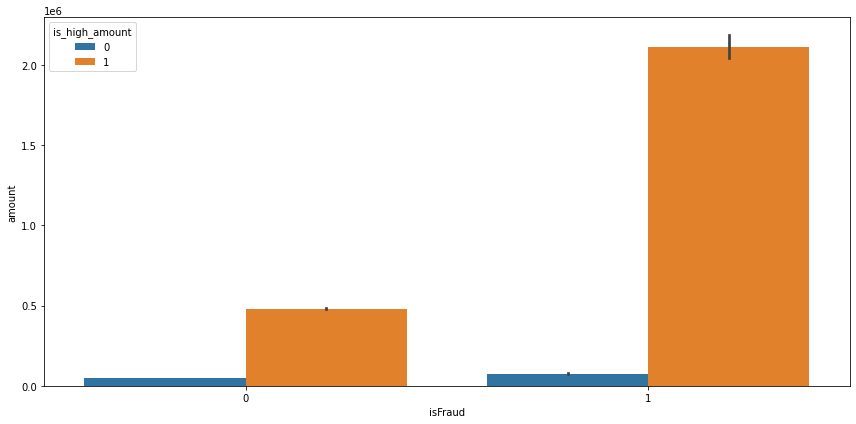

In [36]:
plt.subplots(figsize=(12,6))
sns.barplot(x='isFraud', y='amount', hue='is_high_amount', data=df_1)
plt.tight_layout()

**Hipótese False**

Mesmo que tenhamos uma maior transações fraudulentas com alto valor, também temos as transações não fraudulentas com valores acima da média estipulada.

### 4.1.4. Os clientes destino rotulados com M representa acima de 50% do total de transações fraudulentas.

In [8]:
df_2 = df.copy()
df_2['M_customer'] = np.where(df_2['nameDest'].str.contains('M'), 1,0)

In [11]:
df_2['M_customer'].value_counts(normalize=True)

0   0.66185
1   0.33815
Name: M_customer, dtype: float64

In [15]:
pd.crosstab(df_2.M_customer.astype(str), df_2.isFraud, dropna=False)

isFraud,0,1
M_customer,,
0,4202912,8213
1,2151495,0


**Hipótese Falsa**

Temos entorno de 33% de clientes destinos rotulados com M, porém nenhum deles foram classificados como fraude.

### 4.1.5. Fraude somente ocorre quando o novo balanço de destino está zerado.

In [25]:
df_3 = df.copy()
df_3['new_balance_dest_zero'] = np.where(df_3['newbalanceDest']==0, 1, 0)

In [31]:
pd.crosstab(df_3.new_balance_dest_zero.astype(str), df_3.isFraud, dropna=False)

isFraud,0,1
new_balance_dest_zero,,
0,3919065,4122
1,2435342,4091


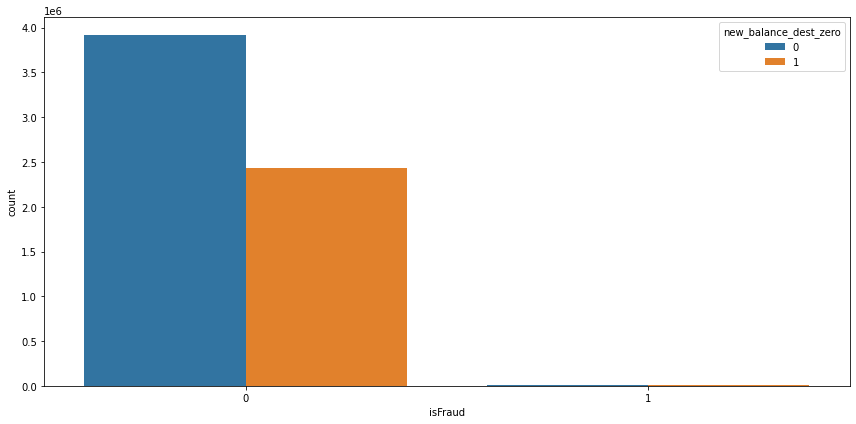

In [34]:
plt.subplots(figsize=(12,6))
sns.countplot(x='isFraud', hue='new_balance_dest_zero', data=df_3)
plt.tight_layout()

**Hipótese Falsa**

Temos fraudes acontecendo quando o novo balanço destino não está zerado.

### 4.1.6. Fraude somente ocorre quando o novo balanço de origem está zerado.

In [38]:
df_4 = df.copy()
df_4['new_balance_orig_zero'] = np.where(df_4['newbalanceOrig']==0, 1, 0)

In [49]:
pd.crosstab(df_4.new_balance_orig_zero.astype(str), df_4.isFraud, dropna=False)

isFraud,0,1
new_balance_orig_zero,,
0,2752894,160
1,3601513,8053


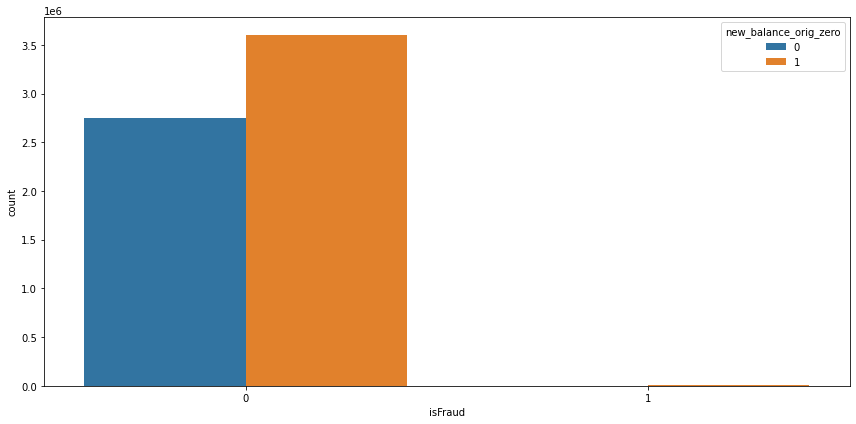

In [39]:
plt.subplots(figsize=(12,6))
sns.countplot(x='isFraud', hue='new_balance_orig_zero', data=df_4)
plt.tight_layout()

**Hipótese Falsa**

Temos fraudes acontecendo quando o novo balanço origem não está zerado.

### 4.1.7. Fraude somente ocorre quando o antigo balanço de destino está zerado.

In [40]:
df_5 = df.copy()
df_5['old_balance_dest_zero'] = np.where(df_5['oldbalanceDest']==0, 1, 0)

In [48]:
pd.crosstab(df_5.old_balance_dest_zero.astype(str), df_5.isFraud, dropna=False)

isFraud,0,1
old_balance_dest_zero,,
0,3655370,2862
1,2699037,5351


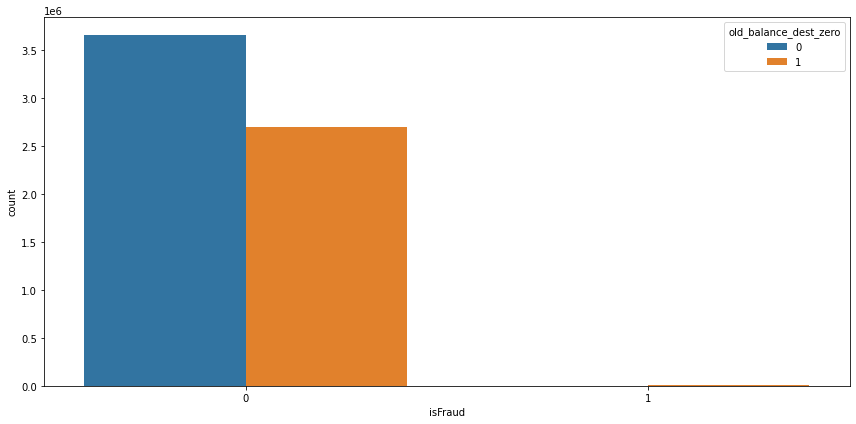

In [41]:
plt.subplots(figsize=(12,6))
sns.countplot(x='isFraud', hue='old_balance_dest_zero', data=df_5)
plt.tight_layout()

**Hipótese Falsa**

Temos fraudes acontecendo quando o antigo balanço destino não está zerado.

### 4.1.8. Fraude somente ocorre quando o antigo balanço de origem está zerado.

In [42]:
df_6 = df.copy()
df_6['old_balance_orig_zero'] = np.where(df_6['oldbalanceOrg']==0, 1, 0)

In [50]:
pd.crosstab(df_6.old_balance_orig_zero.astype(str), df_6.isFraud, dropna=False)

isFraud,0,1
old_balance_orig_zero,,
0,4251999,8172
1,2102408,41


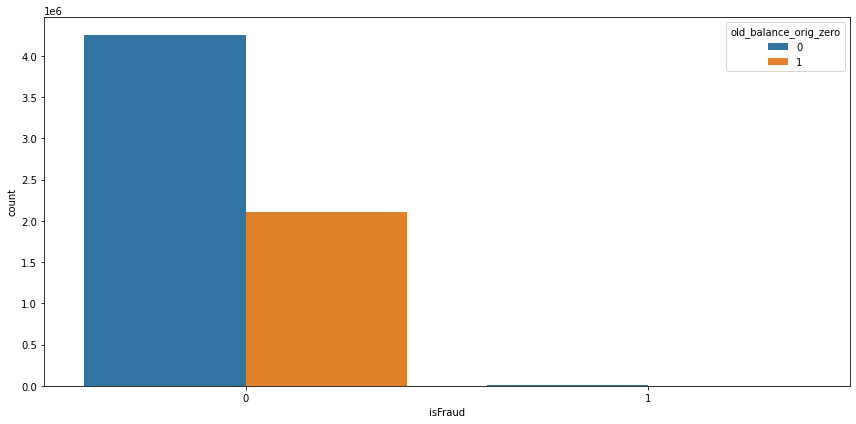

In [44]:
plt.subplots(figsize=(12,6))
sns.countplot(x='isFraud', hue='old_balance_orig_zero', data=df_6)
plt.tight_layout()

**Hipótese Falsa**

Temos fraudes acontecendo quando o antigo balanço origem não está zerado.

### 4.1.9. Clientes que foram classificados como fraude retornam novamente para fraudar.

In [58]:
df_7 = df.loc[df['isFraud']==1].copy()
df_7.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00000,C1305486145,181.00000,0.00000,C553264065,0.00000,0.00000,1,0
3,1,CASH_OUT,181.00000,C840083671,181.00000,0.00000,C38997010,21182.00000,0.00000,1,0
251,1,TRANSFER,2806.00000,C1420196421,2806.00000,0.00000,C972765878,0.00000,0.00000,1,0
252,1,CASH_OUT,2806.00000,C2101527076,2806.00000,0.00000,C1007251739,26202.00000,0.00000,1,0
680,1,TRANSFER,20128.00000,C137533655,20128.00000,0.00000,C1848415041,0.00000,0.00000,1,0


In [67]:
user_orig = df_7.groupby('nameOrig').agg(count_orig=('nameOrig', 'count')).reset_index().sort_values('count_orig', ascending=False)
user_dest = df_7.groupby('nameDest').agg(count_dest=('nameDest', 'count')).reset_index().sort_values('count_dest', ascending=False)

user_orig = user_orig.loc[user_orig['count_orig']>1]
user_dest = user_dest.loc[user_dest['count_dest']>1]

In [77]:
user_orig.nunique()[0]

0

In [78]:
user_dest.nunique()[0]

44

**Hipótese Verdadeira**

Em partes, usuários de origem definidos como fraudes não voltam, porém, os usuários de destino voltam mesmo serem considerados fraudulentos anteriormente.

### 4.1.10. Fraude ocorre quando a diferença entre o antigo balanço, a transação e o novo balanço de origem é maior que a diferença entre a transação e o novo balanço de destino.

In [101]:
df_8 = df[['step', 'oldbalanceOrg', 'oldbalanceDest', 'amount', 'newbalanceOrig', 'newbalanceDest', 'isFraud']].copy()
df_8['diff_orig'] = df_8['oldbalanceOrg'] - df_8['amount'] - df_8['newbalanceOrig']
df_8['diff_dest'] = df_8['oldbalanceDest'] + df_8['amount'] - df_8['newbalanceDest']

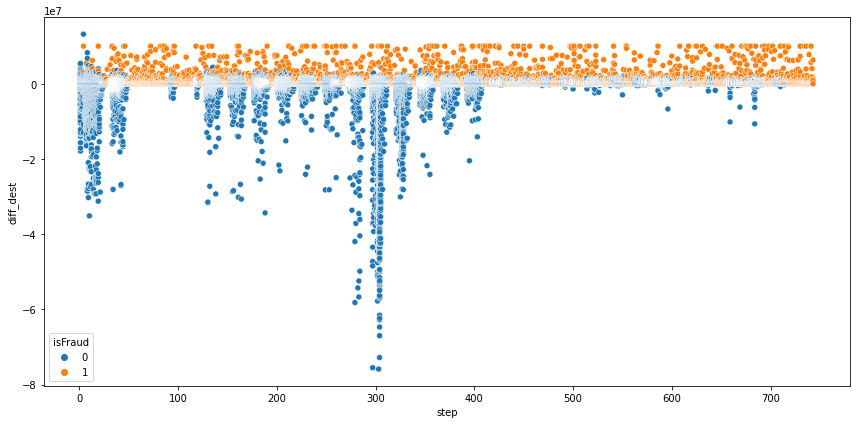

In [104]:
plt.subplots(figsize=(12,6))
sns.scatterplot(x='step', y='diff_dest', hue='isFraud', data=df_8)
plt.tight_layout()

**Hipótese Verdadeira**

Existem fraudes acontecendo quando a diferença entre o antigo balanço, a transação e o novo balanço de origem é maior que a diferença entre a transação e o novo balanço de destino.

### 4.1.11. Hypothesis Summary

In [107]:
# Hypothesis Summary dataframe
pd.set_option('display.max_colwidth', None)
summary = pd.DataFrame({'Hypothesis':['O type CASH_OUT é o mais relacionado à fraude.',
                                      'O type com a maior soma de transação é o que possui mais fraude.',
                                      'A fraude ocorre somente para transações maiores.',
                                      'Os clientes destino rotulados com M representa acima de 50% do total de transações fraudulentas.',
                                      'Fraude somente ocorre quando o novo balanço de destino está zerado.',
                                      'Fraude somente ocorre quando o novo balanço de origem está zerado.',
                                      'Fraude somente ocorre quando o antigo balanço de destino está zerado.',
                                      'Fraude somente ocorre quando o antigo balanço de origem está zerado.',
                                      'Clientes que foram classificados como fraude retornam novamente para fraudar.',
                                      'Fraude ocorre quando a diferença entre o antigo balanço, a transação e o novo balanço de origem é maior que a diferença entre a transação e o novo balanço de destino.',
                                      ],
                        'True / False':['True', 'False', 'False', 'False', 'False', 'False', 'False', 'False', 'True',
                                        'True']}, 
                        index=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
summary

,Hypothesis,True / False
1,O type CASH_OUT é o mais relacionado à fraude.,True
2,O type com a maior soma de transação é o que possui mais fraude.,False
3,A fraude ocorre somente para transações maiores.,False
4,Os clientes destino rotulados com M representa acima de 50% do total de transações fraudulentas.,False
5,Fraude somente ocorre quando o novo balanço de destino está zerado.,False
6,Fraude somente ocorre quando o novo balanço de origem está zerado.,False
7,Fraude somente ocorre quando o antigo balanço de destino está zerado.,False
8,Fraude somente ocorre quando o antigo balanço de origem está zerado.,False
9,Clientes que foram classificados como fraude retornam novamente para fraudar.,True
10,"Fraude ocorre quando a diferença entre o antigo balanço, a transação e o novo balanço de origem é maior que a diferença entre a transação e o novo balanço de destino.",True


## 4.2. Multivariate analysis

### 4.2.1. Correlation numerical features

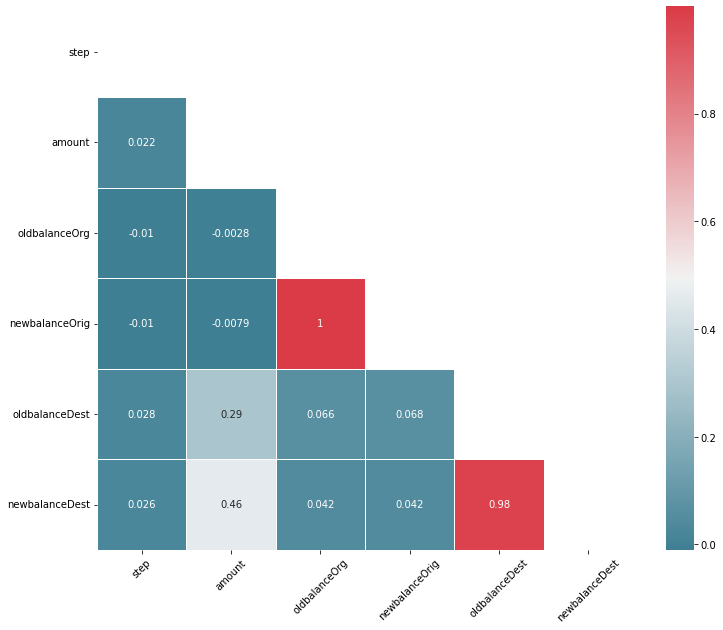

In [109]:
numerical_features = df[['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]
correlations = numerical_features.corr()

# uses the variable ax for single Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(12, 10)

# generates a mask for the upper triangle
mask = np.triu(np.ones_like(correlations, dtype=np.bool))

# generates a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# plots the heatmap
sns.heatmap(correlations, cmap=cmap, mask=mask, linewidth=.5, annot=True)

# rotates the axes ticks
plt.xticks(rotation=45)
plt.yticks(rotation=0)

# displays the plot
plt.show()

## 4.3. Conclusion

Dado as conclusões das hipóteses podemos definir que na próxima etapa de Feature Engineering teremos que criar novas features afim de beneficiar o modelo de machine learning para ele aprender com os inputs, por exemplo, por agora podemos confirmar que a diferença de saldo antes com o novo condiz com fraude. Além disso, podemos pensar em diversas novas formas de arranjar os dados, até por causa de que os dados da variável alvo está bem desbalanceado.

Olhando as correlações, podemos destacar as correlações:
- newbalanceOrig x oldbalanceOrg: possuindo uma correlação perfeita positiva
- newbalanceDest x oldbalanceDest: possuindo uma correlação quase perfeita positiva

É necessário prestar atenção nessas variáveis, podendo ser levadas ao modelo e não ter a performance esperada, pois temos uma alta correlação e ser possível identificar colinearidade das variáveis.